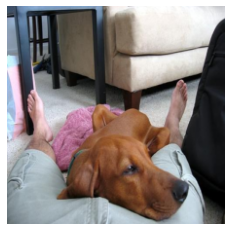

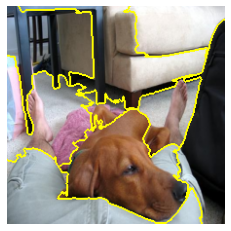

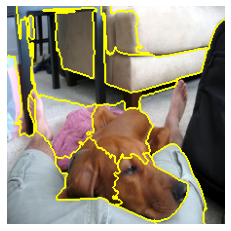

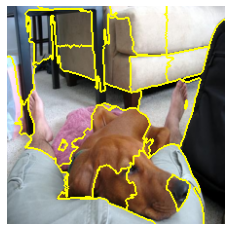

In [63]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

In [19]:
import os, glob
import torch
import numpy as np
import scipy.io
from skimage.color import rgb2lab
import matplotlib.pyplot as plt


def convert_label(label):

    onehot = np.zeros((1, 50, label.shape[0], label.shape[1])).astype(np.float32)

    ct = 0
    for t in np.unique(label).tolist():
        if ct >= 50:
            break
        else:
            onehot[:, ct, :, :] = (label == t)
        ct = ct + 1

    return onehot


class BSDS:
    def __init__(self, root, split="train", color_transforms=None, geo_transforms=None):
        self.gt_dir = r"F:\data\BSDS500\data\ground_truth\train"# os.path.join(root, "BSDS500\\data\\groundTruth", split)
        self.img_dir = r"F:\data\BSDS500\data\images\train" #os.path.join(root, "BSDS500\\data\\images", split)

        self.index = os.listdir(self.gt_dir)

        self.color_transforms = color_transforms
        self.geo_transforms = geo_transforms


    def __getitem__(self, idx):
        idx = self.index[idx][:-4]
        gt = scipy.io.loadmat(os.path.join(self.gt_dir, idx+".mat"))
        t = np.random.randint(0, len(gt['groundTruth'][0]))
        gt = gt['groundTruth'][0][t][0][0][0]

        img = rgb2lab(plt.imread(os.path.join(self.img_dir, idx+".jpg")))

        gt = gt.astype(np.int64)
        img = img.astype(np.float32)

        if self.color_transforms is not None:
            img = self.color_transforms(img)

        if self.geo_transforms is not None:
            img, gt = self.geo_transforms([img, gt])

        gt = convert_label(gt)
        gt = torch.from_numpy(gt)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)

        return img, gt.reshape(50, -1).float()


    def __len__(self):
        return len(self.index)

In [37]:
dataset = BSDS('F:\\data')
# "F:\data\BSDS500\data\ground_truth\train"
img, label = dataset.__getitem__(51)

[[  1   1   0 ...   9   9   9]
 [  1   0   0 ...   9   9   9]
 [  1   0   0 ...   9   9   9]
 ...
 [  0   0   0 ... 730   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


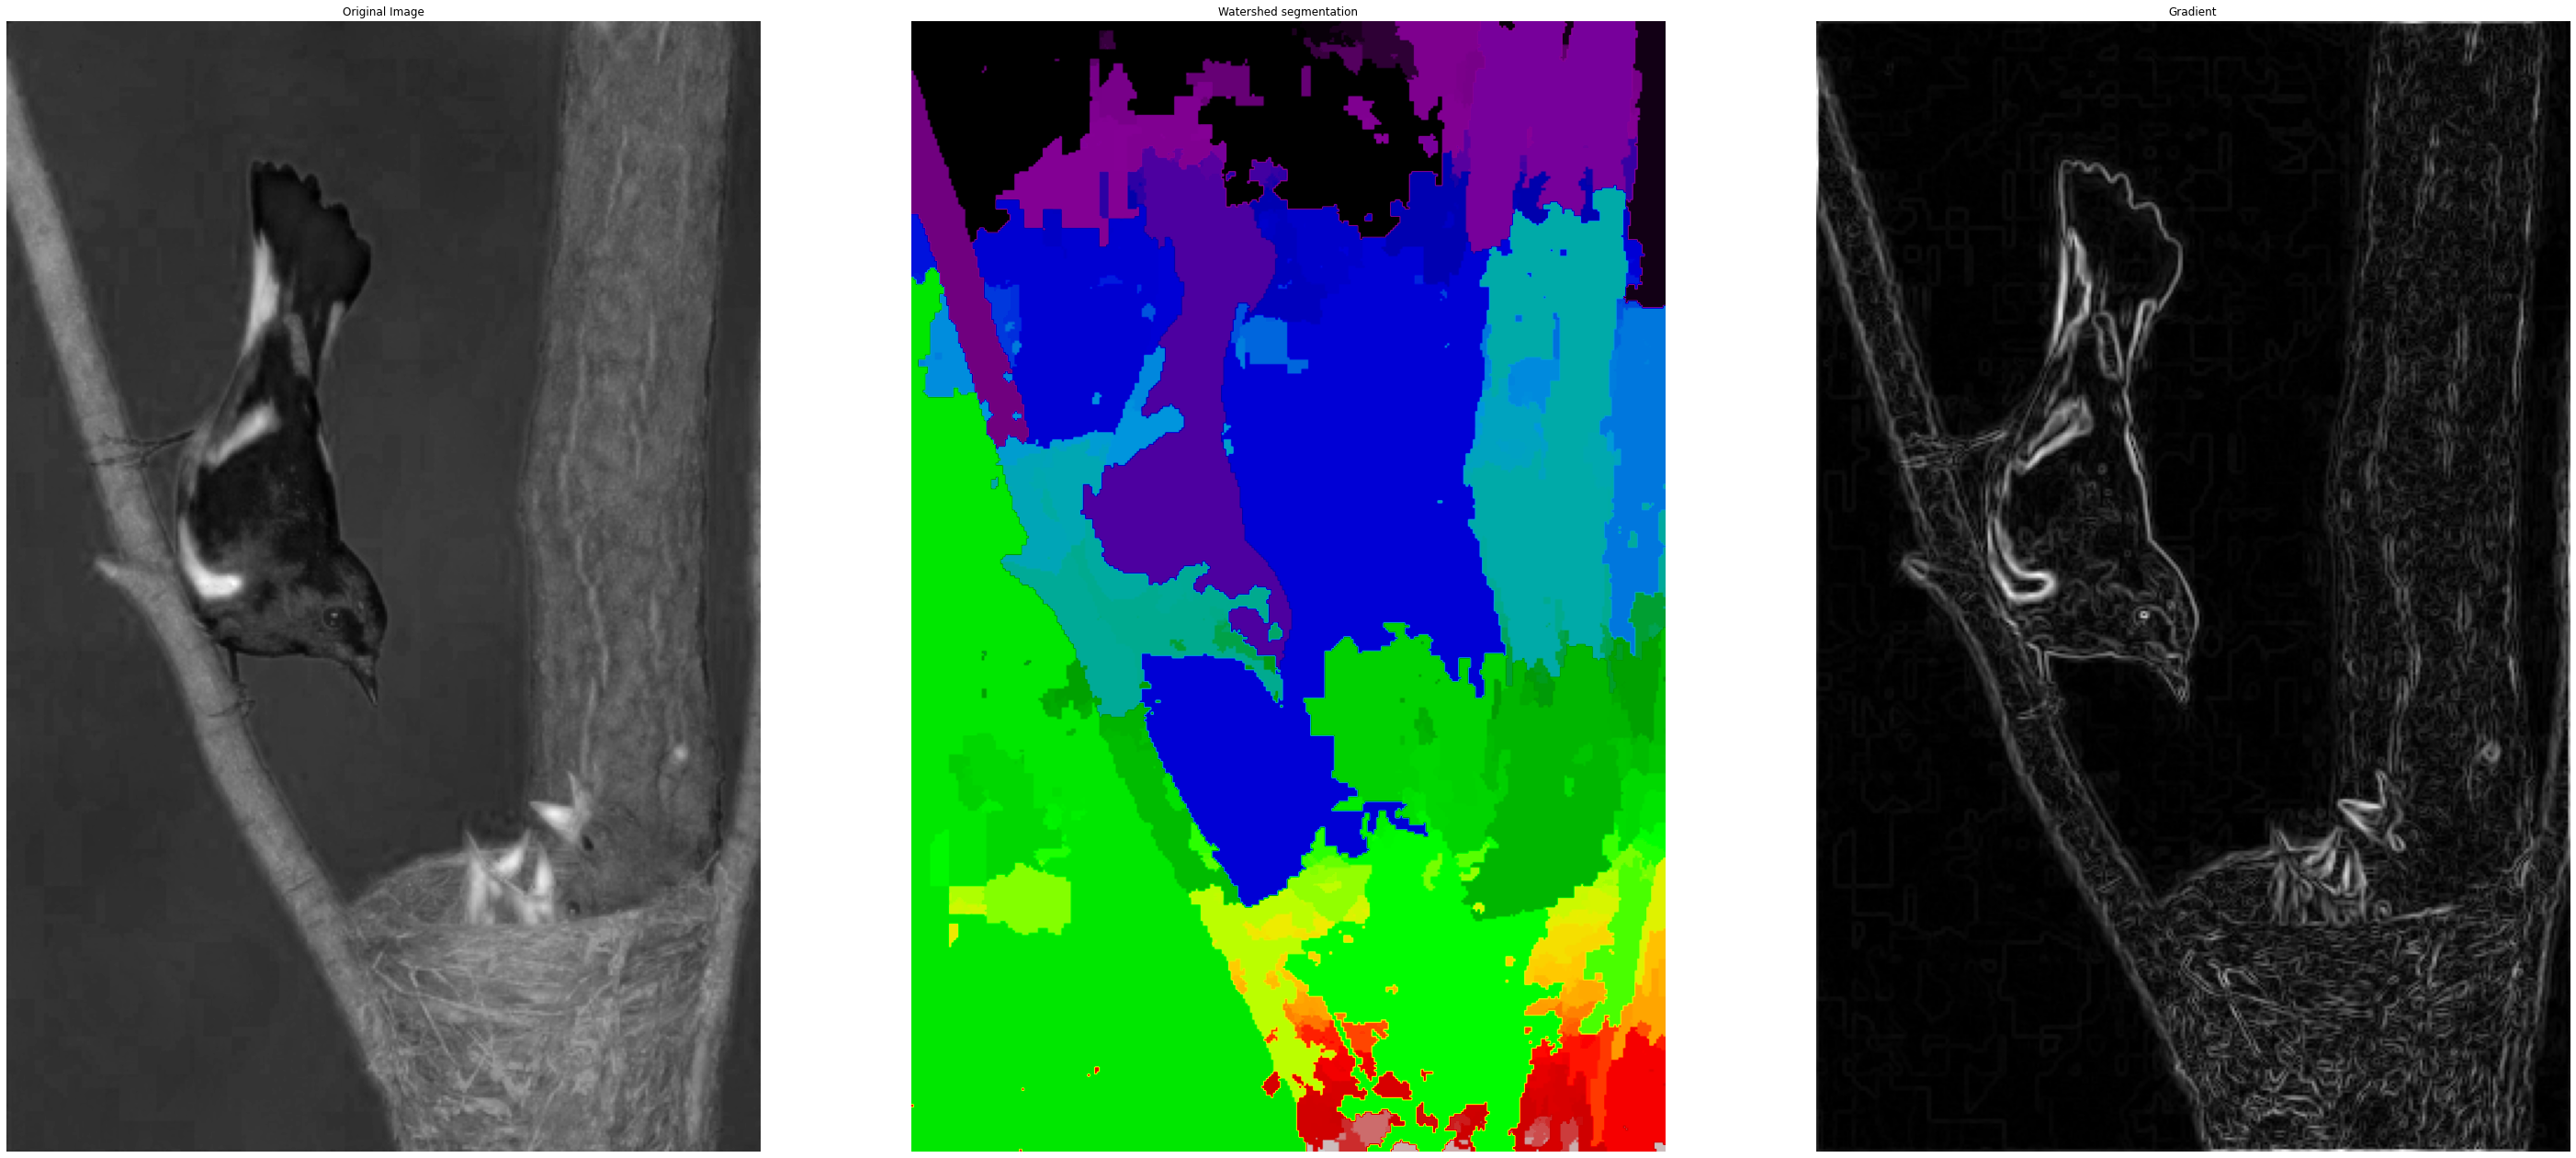

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F


def sobel_filter(image):
    """Instead of fixed sobel kernels can we make the parameters in the kernels learnable? This could let the model learn the optimal edge detection filters"""
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        return np.array(True, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    return output <= connectivity

def connected_components(input, structure=None):
    input = np.asarray(input)
    if np.iscomplexobj(input):
        raise TypeError('Complex type not supported')

    if structure is None:
        structure = generate_binary_structure(input.ndim, 1)
    structure = np.asarray(structure, dtype=bool)
    
    if structure.ndim != input.ndim:
        raise RuntimeError('structure and input must have equal rank')
    for ii in structure.shape:
        if ii != 3:
            raise ValueError('structure dimensions must be equal to 3')

    output = np.zeros(input.shape, np.int32)
    label = 1
    max_label = 0

    def flood_fill(x, y, label):
        queue = [(x, y)]
        while queue:
            cx, cy = queue.pop(0)
            if output[cx, cy] == 0 and input[cx, cy]:
                output[cx, cy] = label
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < input.shape[0] and 0 <= ny < input.shape[1]:
                        queue.append((nx, ny))

    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            if input[i, j] and output[i, j] == 0:
                flood_fill(i, j, label)
                label += 1
                max_label = label - 1

    return output, max_label


def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers
    """
    these markers is to identifies specific regions in the image that will serve as starting points (seeds) for the watershed algorithm. In traditional watershed segmentation:
    Low-Intensity Markers (1): These typically correspond to the darker regions in the image, which could represent background or specific objects of interest.
    High-Intensity Markers (2): These typically correspond to the brighter regions in the image, which could represent different objects or features of interest.
    
    By using these markers, the watershed algorithm can "flood" the image from these predefined seed points, allowing for more controlled and accurate segmentation of different regions within the image.
    Instead of using percentiles, could we make the placement of the markers learnable instead?
    """
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    """
    The flooding process inherently involves non-differentiable operations like heap-based priority queues. 
    To make this differentiable, we can approximate the process using differentiable operations, 
    such as softmax for computing probabilities of pixel assignments.
    """
    labeled, _ = connected_components(markers)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(50, 50))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(gradient, cmap='gray')
    plt.title('Gradient')
    plt.axis('off')
    
    plt.show()
    


watershed_from_scratch(img.permute(1, 2, 0))

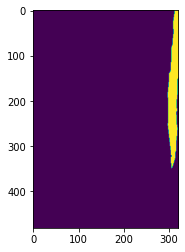

In [55]:
plt.imshow(label.view(50, img.shape[1], img.shape[2])[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


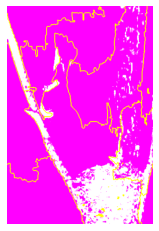

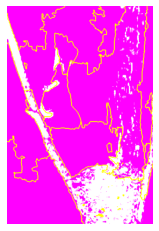

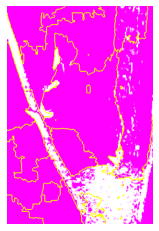

In [65]:
gradient = sobel(rgb2gray(img.permute(1, 2, 0).numpy()))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(img.permute(1,2,0).numpy(), segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

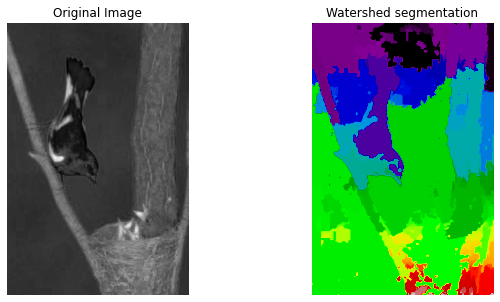

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel

def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel(image)

    # Generate markers
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    from scipy.ndimage import label, generate_binary_structure
    labeled, _ = label(markers)
    
    structure = generate_binary_structure(2, 2)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()


watershed_from_scratch(img.permute(1, 2, 0))

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\distransform.cpp:724: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::distanceTransform'


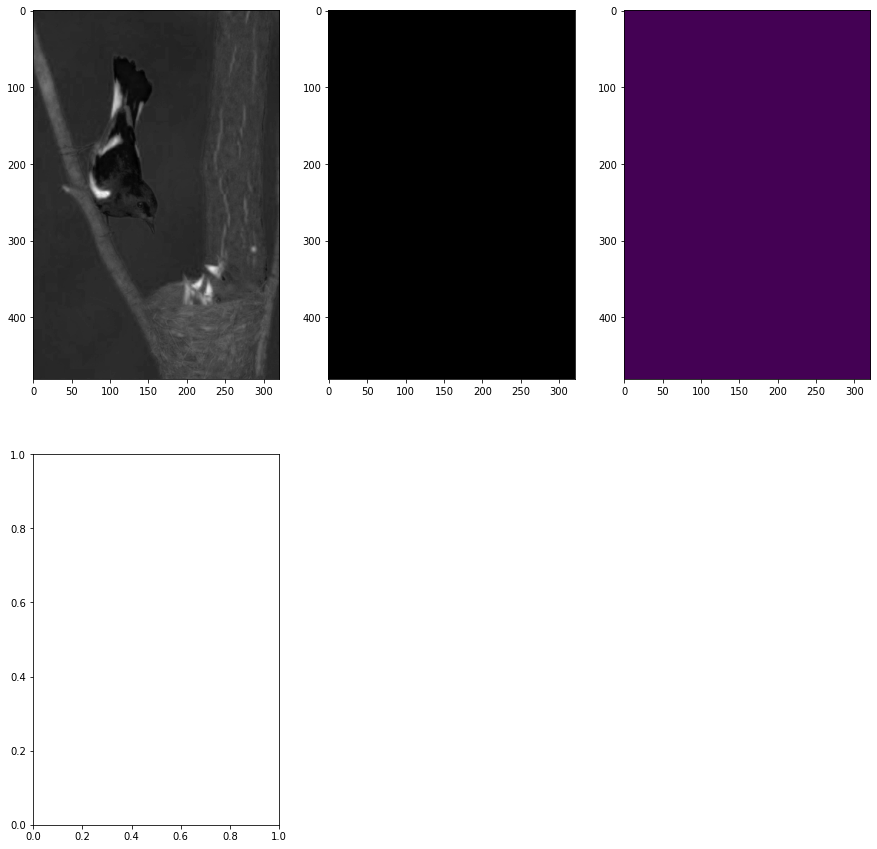

In [61]:
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np
import os

def watershed(img):
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(231)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(232)
    _, imageThreshold = cv.threshold(img,120,255,cv.THRESH_BINARY_INV)
    plt.imshow(imageThreshold, cmap='gray')
    
    plt.subplot(233)
    kernel = np.ones((3,3),np.uint8)
    imgDilate = cv.morphologyEx(imageThreshold, cv.MORPH_DILATE, kernel)
    plt.imshow(imgDilate)
    
    plt.subplot(234)
    dist_transform = cv.distanceTransform(imgDilate, cv.DIST_L2, 5)
    plt.imshow(dist_transform)
    
    plt.subplot(235)
    _, distThresh = cv.threshold(dist_transform, 15, 255, cv.THRESH_BINARY)
    plt.imshow(distThresh)
    
    plt.subplot(236)
    distThresh = np.uint8(distThresh)
    _, labels = cv.connectedComponents(distThresh)
    plt.imshow(labels)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    labels = np.int32(labels)
    labels = cv.watershed(imgRGB, labels)
    plt.imshow(labels)
    
    plt.subplot(122)
    imgRGB[labels == -1] = [0,255,0]
    plt.imshow(imgRGB)
    
    
    plt.show()
    
watershed(img.permute(1, 2, 0).numpy())